In [77]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
df = pd.read_csv('feature_selection_top_states.csv', parse_dates = True)
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,...,NATIVE_PEOPLES,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT,PROVINCE_STATE_NAME
0,2020-03-01,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California
1,2020-03-02,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California
2,2020-03-03,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,7,California
3,2020-03-04,1.0,1.0,0.0,112.5,0.0,1.0,1.0,0.0,0.0,...,873999,0.0,0.0,24.685185,1.860398,5.818187,1.71647,0.0,10,California
4,2020-03-05,1.0,1.0,0.0,112.5,0.0,1.0,1.0,1.0,0.0,...,873999,0.0,0.0,25.753086,1.860398,5.818187,1.71647,0.0,12,California


In [78]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']
ca_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
ca_df.head(3)

,Date,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,...,new_cases_100_mean,NATIVE_PEOPLES,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT
0,2020-03-01,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,1107.65,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5
1,2020-03-02,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,1018.62,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5
2,2020-03-03,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,...,939.63,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,7


In [79]:
#separate train & test sets
train_size = int(len(ca_df)* 0.85)
ca_train, ca_test = ca_df[0:train_size], ca_df[train_size:]

In [80]:
#identify best features among 179 using PCA -- to help speed up 
X_ca_train = ca_train.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
X_ca_test = ca_test.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
y_ca_train = ca_train['PEOPLE_POSITIVE_NEW_CASES_COUNT']
y_ca_test = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT']

# Keep the 'Date' column separate and not to be scaled or PCA-transformed
Date_train = X_ca_train[['Date']].reset_index(drop=True)
Date_test = X_ca_test[['Date']].reset_index(drop=True)

# Exclude the 'Date' column from scaling and PCA
X_train_ca_numerical = X_ca_train.drop(columns=['Date'])
X_test_ca_numerical = X_ca_test.drop(columns=['Date'])


#standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ca_numerical)
X_test_scaled = scaler.fit_transform(X_test_ca_numerical)

#PCA to reduce the features to the top 40 principal components 
pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

#transformed data `X_pca` has only the top 40 principal components now
X_train_pca_df = pd.DataFrame(data = X_train_pca)
X_test_pca_df = pd.DataFrame(data = X_test_pca)

# Concatenate the PCA components with the 'Date' column
X_train_final = pd.concat([Date_train, X_train_pca_df], axis=1)
X_test_final = pd.concat([Date_test, X_test_pca_df], axis=1)

In [81]:
#forward selection algorithm to determine optimal feature combination for multivariate prophet model
target_column = 'PEOPLE_POSITIVE_NEW_CASES_COUNT'

#forward selection function to include target data as separate arguments
def forward_selection(train_df, test_df, y_train, y_test, target_column):
    train_df.columns = train_df.columns.astype(str)
    test_df.columns = test_df.columns.astype(str)

    features = [col for col in train_df.columns if col != 'Date']
    included_features = []
    best_mae = np.inf
    improvement = True
    
    while improvement and features:
        improvement = False
        for feature in features:
            test_features = included_features + [feature]
            
            # Initialize and setup Prophet model
            model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
            for f in test_features:
                model.add_regressor(f, standardize=False)
                
            # Prepare training data
            train_data = train_df[['Date'] + test_features]
            train_data['y'] = y_train
            train_data = train_data.rename(columns={'Date': 'ds'})
            
            model.fit(train_data)
            
            # Prepare testing data
            test_data = test_df[['Date'] + test_features]
            test_data['y'] = y_test  # This line is not used for prediction but kept for consistency
            test_data = test_data.rename(columns={'Date': 'ds'})
            
            forecast = model.predict(test_data.drop(columns=['y']))
            
            # Evaluate the model
            mae = mean_absolute_error(y_test, forecast['yhat'])
            
            if mae < best_mae:
                best_feature = feature
                best_mae = mae
                improvement = True
                
        if improvement:
            included_features.append(best_feature)
            features.remove(best_feature)
            print(f"Added {best_feature} to the model, new best MAE: {best_mae}")
    
    print(f"Final features selected: {included_features}")
    return included_features

In [82]:
# Run the updated forward selection
selected_features = forward_selection(X_train_final, X_test_final, y_ca_train, y_ca_test, target_column)

02:11:17 - cmdstanpy - INFO - Chain [1] start processing
02:11:17 - cmdstanpy - INFO - Chain [1] done processing
02:11:17 - cmdstanpy - INFO - Chain [1] start processing
02:11:17 - cmdstanpy - INFO - Chain [1] done processing
02:11:17 - cmdstanpy - INFO - Chain [1] start processing
02:11:17 - cmdstanpy - INFO - Chain [1] done processing
02:11:18 - cmdstanpy - INFO - Chain [1] start processing
02:11:18 - cmdstanpy - INFO - Chain [1] done processing
02:11:18 - cmdstanpy - INFO - Chain [1] start processing
02:11:18 - cmdstanpy - INFO - Chain [1] done processing
02:11:18 - cmdstanpy - INFO - Chain [1] start processing
02:11:18 - cmdstanpy - INFO - Chain [1] done processing
02:11:18 - cmdstanpy - INFO - Chain [1] start processing
02:11:18 - cmdstanpy - INFO - Chain [1] done processing
02:11:19 - cmdstanpy - INFO - Chain [1] start processing
02:11:19 - cmdstanpy - INFO - Chain [1] done processing
02:11:19 - cmdstanpy - INFO - Chain [1] start processing
02:11:19 - cmdstanpy - INFO - Chain [1]

Added 2 to the model, new best MAE: 25519.369630227517


02:11:27 - cmdstanpy - INFO - Chain [1] done processing
02:11:27 - cmdstanpy - INFO - Chain [1] start processing
02:11:27 - cmdstanpy - INFO - Chain [1] done processing
02:11:27 - cmdstanpy - INFO - Chain [1] start processing
02:11:27 - cmdstanpy - INFO - Chain [1] done processing
02:11:28 - cmdstanpy - INFO - Chain [1] start processing
02:11:28 - cmdstanpy - INFO - Chain [1] done processing
02:11:28 - cmdstanpy - INFO - Chain [1] start processing
02:11:28 - cmdstanpy - INFO - Chain [1] done processing
02:11:28 - cmdstanpy - INFO - Chain [1] start processing
02:11:28 - cmdstanpy - INFO - Chain [1] done processing
02:11:28 - cmdstanpy - INFO - Chain [1] start processing
02:11:28 - cmdstanpy - INFO - Chain [1] done processing
02:11:29 - cmdstanpy - INFO - Chain [1] start processing
02:11:29 - cmdstanpy - INFO - Chain [1] done processing
02:11:29 - cmdstanpy - INFO - Chain [1] start processing
02:11:29 - cmdstanpy - INFO - Chain [1] done processing
02:11:29 - cmdstanpy - INFO - Chain [1] 

Added 11 to the model, new best MAE: 24078.44350654678


02:11:37 - cmdstanpy - INFO - Chain [1] done processing
02:11:37 - cmdstanpy - INFO - Chain [1] start processing
02:11:37 - cmdstanpy - INFO - Chain [1] done processing
02:11:38 - cmdstanpy - INFO - Chain [1] start processing
02:11:38 - cmdstanpy - INFO - Chain [1] done processing
02:11:38 - cmdstanpy - INFO - Chain [1] start processing
02:11:38 - cmdstanpy - INFO - Chain [1] done processing
02:11:38 - cmdstanpy - INFO - Chain [1] start processing
02:11:38 - cmdstanpy - INFO - Chain [1] done processing
02:11:39 - cmdstanpy - INFO - Chain [1] start processing
02:11:39 - cmdstanpy - INFO - Chain [1] done processing
02:11:39 - cmdstanpy - INFO - Chain [1] start processing
02:11:39 - cmdstanpy - INFO - Chain [1] done processing
02:11:39 - cmdstanpy - INFO - Chain [1] start processing
02:11:39 - cmdstanpy - INFO - Chain [1] done processing
02:11:39 - cmdstanpy - INFO - Chain [1] start processing
02:11:39 - cmdstanpy - INFO - Chain [1] done processing
02:11:40 - cmdstanpy - INFO - Chain [1] 

Added 8 to the model, new best MAE: 23686.163196074038


02:11:48 - cmdstanpy - INFO - Chain [1] done processing
02:11:48 - cmdstanpy - INFO - Chain [1] start processing
02:11:48 - cmdstanpy - INFO - Chain [1] done processing
02:11:49 - cmdstanpy - INFO - Chain [1] start processing
02:11:49 - cmdstanpy - INFO - Chain [1] done processing
02:11:49 - cmdstanpy - INFO - Chain [1] start processing
02:11:49 - cmdstanpy - INFO - Chain [1] done processing
02:11:49 - cmdstanpy - INFO - Chain [1] start processing
02:11:49 - cmdstanpy - INFO - Chain [1] done processing
02:11:50 - cmdstanpy - INFO - Chain [1] start processing
02:11:50 - cmdstanpy - INFO - Chain [1] done processing
02:11:50 - cmdstanpy - INFO - Chain [1] start processing
02:11:50 - cmdstanpy - INFO - Chain [1] done processing
02:11:50 - cmdstanpy - INFO - Chain [1] start processing
02:11:50 - cmdstanpy - INFO - Chain [1] done processing
02:11:51 - cmdstanpy - INFO - Chain [1] start processing
02:11:51 - cmdstanpy - INFO - Chain [1] done processing
02:11:51 - cmdstanpy - INFO - Chain [1] 

Added 7 to the model, new best MAE: 22997.470209927233


02:12:02 - cmdstanpy - INFO - Chain [1] done processing
02:12:02 - cmdstanpy - INFO - Chain [1] start processing
02:12:02 - cmdstanpy - INFO - Chain [1] done processing
02:12:03 - cmdstanpy - INFO - Chain [1] start processing
02:12:03 - cmdstanpy - INFO - Chain [1] done processing
02:12:03 - cmdstanpy - INFO - Chain [1] start processing
02:12:03 - cmdstanpy - INFO - Chain [1] done processing
02:12:03 - cmdstanpy - INFO - Chain [1] start processing
02:12:04 - cmdstanpy - INFO - Chain [1] done processing
02:12:04 - cmdstanpy - INFO - Chain [1] start processing
02:12:04 - cmdstanpy - INFO - Chain [1] done processing
02:12:04 - cmdstanpy - INFO - Chain [1] start processing
02:12:04 - cmdstanpy - INFO - Chain [1] done processing
02:12:05 - cmdstanpy - INFO - Chain [1] start processing
02:12:05 - cmdstanpy - INFO - Chain [1] done processing
02:12:05 - cmdstanpy - INFO - Chain [1] start processing
02:12:05 - cmdstanpy - INFO - Chain [1] done processing
02:12:05 - cmdstanpy - INFO - Chain [1] 

Added 9 to the model, new best MAE: 22890.579292977225


02:12:23 - cmdstanpy - INFO - Chain [1] done processing
02:12:23 - cmdstanpy - INFO - Chain [1] start processing
02:12:23 - cmdstanpy - INFO - Chain [1] done processing
02:12:24 - cmdstanpy - INFO - Chain [1] start processing
02:12:24 - cmdstanpy - INFO - Chain [1] done processing
02:12:24 - cmdstanpy - INFO - Chain [1] start processing
02:12:24 - cmdstanpy - INFO - Chain [1] done processing
02:12:24 - cmdstanpy - INFO - Chain [1] start processing
02:12:24 - cmdstanpy - INFO - Chain [1] done processing
02:12:25 - cmdstanpy - INFO - Chain [1] start processing
02:12:25 - cmdstanpy - INFO - Chain [1] done processing
02:12:25 - cmdstanpy - INFO - Chain [1] start processing
02:12:25 - cmdstanpy - INFO - Chain [1] done processing
02:12:26 - cmdstanpy - INFO - Chain [1] start processing
02:12:26 - cmdstanpy - INFO - Chain [1] done processing
02:12:26 - cmdstanpy - INFO - Chain [1] start processing
02:12:26 - cmdstanpy - INFO - Chain [1] done processing
02:12:26 - cmdstanpy - INFO - Chain [1] 

Added 4 to the model, new best MAE: 21699.22006651442


02:12:38 - cmdstanpy - INFO - Chain [1] done processing
02:12:38 - cmdstanpy - INFO - Chain [1] start processing
02:12:38 - cmdstanpy - INFO - Chain [1] done processing
02:12:39 - cmdstanpy - INFO - Chain [1] start processing
02:12:39 - cmdstanpy - INFO - Chain [1] done processing
02:12:39 - cmdstanpy - INFO - Chain [1] start processing
02:12:39 - cmdstanpy - INFO - Chain [1] done processing
02:12:40 - cmdstanpy - INFO - Chain [1] start processing
02:12:40 - cmdstanpy - INFO - Chain [1] done processing
02:12:40 - cmdstanpy - INFO - Chain [1] start processing
02:12:40 - cmdstanpy - INFO - Chain [1] done processing
02:12:41 - cmdstanpy - INFO - Chain [1] start processing
02:12:41 - cmdstanpy - INFO - Chain [1] done processing
02:12:41 - cmdstanpy - INFO - Chain [1] start processing
02:12:41 - cmdstanpy - INFO - Chain [1] done processing
02:12:42 - cmdstanpy - INFO - Chain [1] start processing
02:12:42 - cmdstanpy - INFO - Chain [1] done processing
02:12:42 - cmdstanpy - INFO - Chain [1] 

Final features selected: ['2', '11', '8', '7', '9', '4']


In [83]:
train_final = pd.concat([X_train_final, y_ca_train], axis = 1)

#reset the index of both test dfs to ensure they align correctly
X_test_reset = X_test_final.reset_index(drop=True)
y_test_reset = y_ca_test.reset_index(drop=True)

#concat the dfs side by side using the reset indexes
test_final = pd.concat([X_test_reset, y_test_reset], axis=1)

In [84]:
train_final = train_final.rename(columns = {'Date' : 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
test_final = test_final.rename(columns = {'Date' : 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

In [85]:
# Combine them vertically
full_df = pd.concat([train_final, test_final], ignore_index=True)

MULTIVARIATE PROPHET MDOEL WITH VARIABLES REVEALED VIA FORWARD SELECTION

In [86]:
# Initialize the model with seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add each regressor individually
regressor_names = ['2', '11', '8', '4', '9', '7', '31', '3', '22']
for name in regressor_names:
    model_multivariate.add_regressor(name, standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(train_final)


02:12:53 - cmdstanpy - INFO - Chain [1] start processing
02:12:53 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=16)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, full_df[['ds', '2', '11', '8', '4', '9', '7', '31', '3', '22']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,2,11,8,4,9,7,31,3,22
677,2022-01-07,3.068745,0.523138,0.993774,-0.262017,-0.433952,0.169978,4.749799e-16,0.764774,0.152940
678,2022-01-08,3.142950,-0.263836,-1.026436,0.288796,0.092115,0.282021,-5.579988e-16,0.595783,0.101099
679,2022-01-09,2.991846,-0.519752,0.668462,-0.264779,-0.298444,-0.582936,-1.302357e-16,0.793508,0.019309
680,2022-01-10,1.406547,-0.405175,0.596348,-0.132328,0.337676,0.427915,-1.662197e-16,-0.072682,-0.055941
681,2022-01-11,-0.099808,0.972877,-1.940356,0.194200,0.617118,1.489089,2.032235e-16,-1.398290,-0.184953
682,2022-01-12,-0.229490,0.252924,-0.614570,0.294250,-0.345708,-2.618619,-4.506808e-16,-1.108080,-0.011250
683,2022-01-13,-0.729553,1.148529,1.902424,0.131062,-0.397548,-1.257430,1.203500e-15,-1.205184,0.025699
684,2022-01-14,-1.133354,0.190269,-0.527788,0.450021,-0.458005,1.133101,-2.733292e-16,-1.642054,0.131024
685,2022-01-15,-0.549081,-0.031584,-0.226746,0.621068,0.217306,-1.062289,1.029828e-16,-1.255025,0.016324
686,2022-01-16,-0.830629,-0.120559,1.083215,0.114081,0.300182,-0.941598,-6.405931e-16,-1.134593,-0.271961


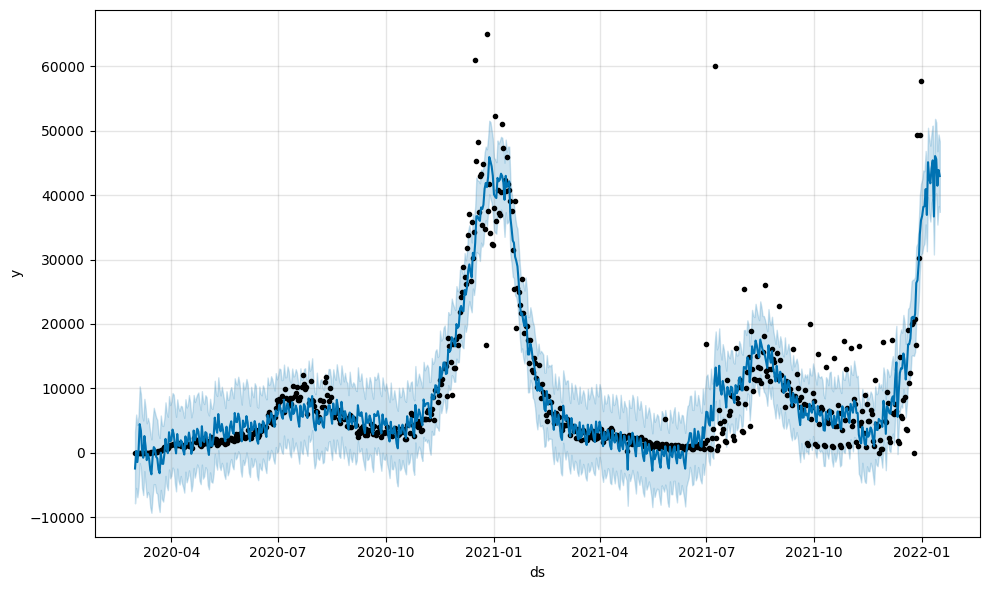

In [88]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

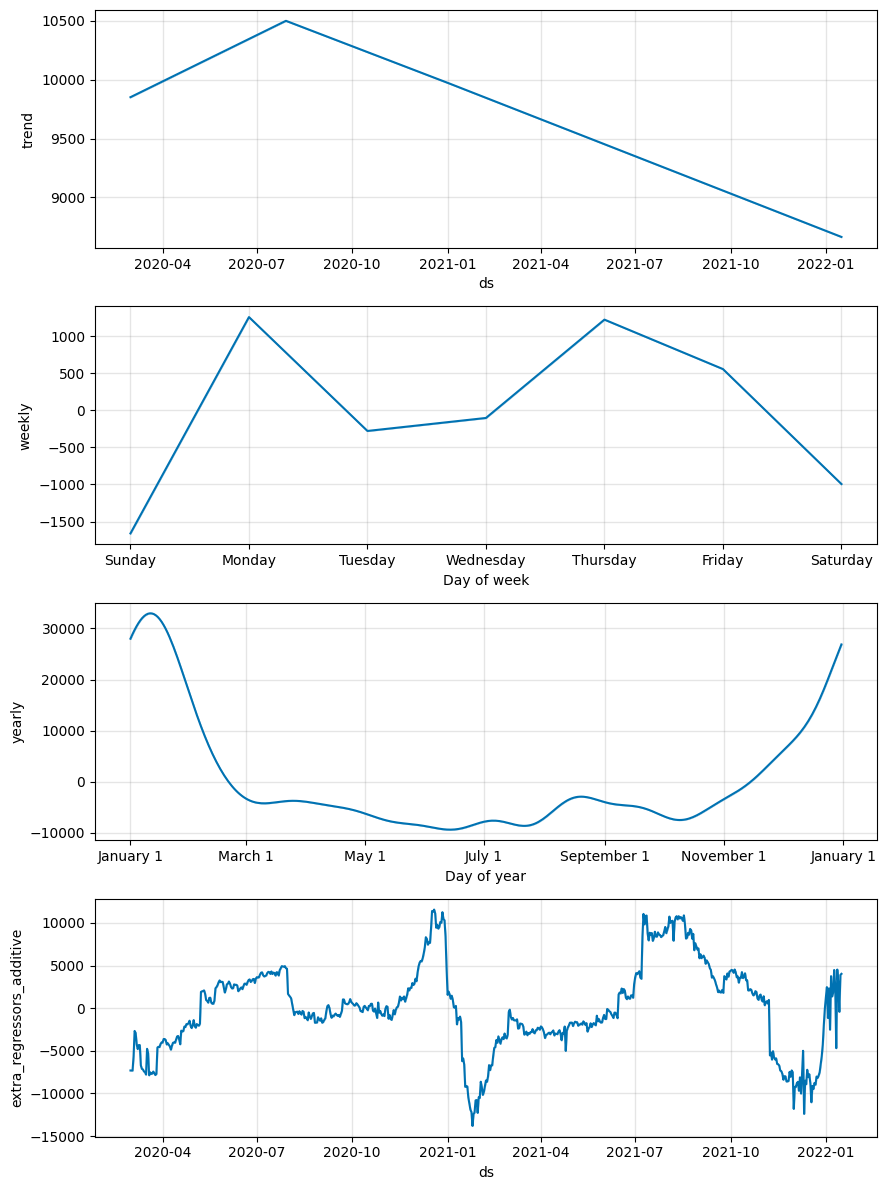

In [89]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [90]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test_final, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 51852.48718144334
The MAPE for the multivariate model is 1.035087276586433e+19


MODEL WITH HOLIDAY AND EVENT EFFECTS

In [91]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2020-02-02,-7,1
1,superbowl,2021-02-07,-7,1


In [92]:
# Initialize the model with seasonality
model_holiday = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = events)

# Add each regressor individually
regressor_names = ['2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']
for name in regressor_names:
    model_holiday.add_regressor(name, standardize=False)

# Fit the model on the training dataset
model_holiday.fit(train_final)

#all the holidays / events
model_holiday.train_holiday_names

02:12:56 - cmdstanpy - INFO - Chain [1] start processing
02:12:57 - cmdstanpy - INFO - Chain [1] done processing


0        COVID
1    superbowl
dtype: object

In [93]:
# Create the time range for the forecast
future_multivariate_holiday = model_holiday.make_future_dataframe(periods=120)

# Append the regressor values
future_multivariate_holiday = pd.merge(future_multivariate_holiday, full_df[['ds', '2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate_holiday = future_multivariate_holiday.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,2,11,8,4,9,7,31,3,22
677,2022-01-07,3.068745,0.523138,0.993774,-0.262017,-0.433952,0.169978,4.749799e-16,0.764774,0.152940
678,2022-01-08,3.142950,-0.263836,-1.026436,0.288796,0.092115,0.282021,-5.579988e-16,0.595783,0.101099
679,2022-01-09,2.991846,-0.519752,0.668462,-0.264779,-0.298444,-0.582936,-1.302357e-16,0.793508,0.019309
680,2022-01-10,1.406547,-0.405175,0.596348,-0.132328,0.337676,0.427915,-1.662197e-16,-0.072682,-0.055941
681,2022-01-11,-0.099808,0.972877,-1.940356,0.194200,0.617118,1.489089,2.032235e-16,-1.398290,-0.184953
682,2022-01-12,-0.229490,0.252924,-0.614570,0.294250,-0.345708,-2.618619,-4.506808e-16,-1.108080,-0.011250
683,2022-01-13,-0.729553,1.148529,1.902424,0.131062,-0.397548,-1.257430,1.203500e-15,-1.205184,0.025699
684,2022-01-14,-1.133354,0.190269,-0.527788,0.450021,-0.458005,1.133101,-2.733292e-16,-1.642054,0.131024
685,2022-01-15,-0.549081,-0.031584,-0.226746,0.621068,0.217306,-1.062289,1.029828e-16,-1.255025,0.016324
686,2022-01-16,-0.830629,-0.120559,1.083215,0.114081,0.300182,-0.941598,-6.405931e-16,-1.134593,-0.271961


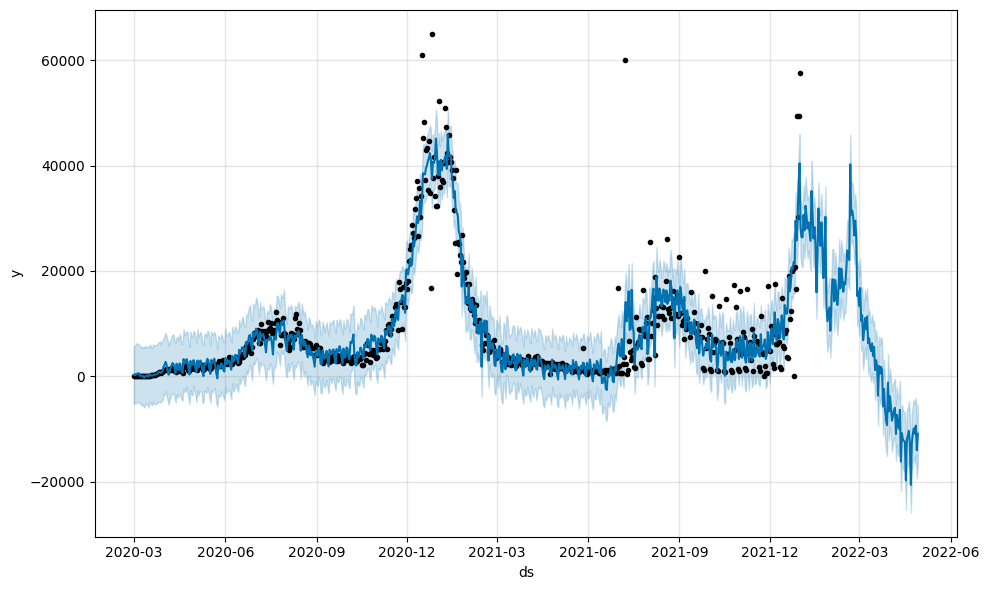

In [94]:
# Make prediction
forecast_holiday = model_holiday.predict(future_multivariate_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday);

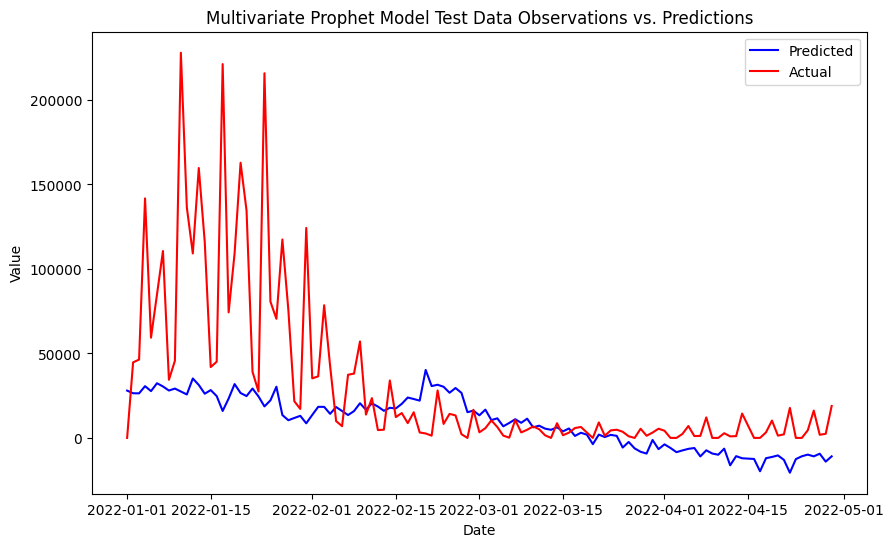

In [108]:
# Predictions are already made in forecast_holiday, you need to filter this for the test period
test_period_start = test_final['ds'].min()
test_period_end = test_final['ds'].max()
forecast_test_period = forecast_holiday[(forecast_holiday['ds'] >= test_period_start)]

# Plot the predictions for the test period
plt.figure(figsize=(10, 6))
plt.plot(forecast_test_period['ds'], forecast_test_period['yhat'], label='Predicted', color='blue')

# Overlay the actual test data
plt.plot(test_final['ds'], test_final['y'], color='red', label='Actual')

# Enhance the plot with labels and legend
plt.legend()
plt.title('Multivariate Prophet Model Test Data Observations vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


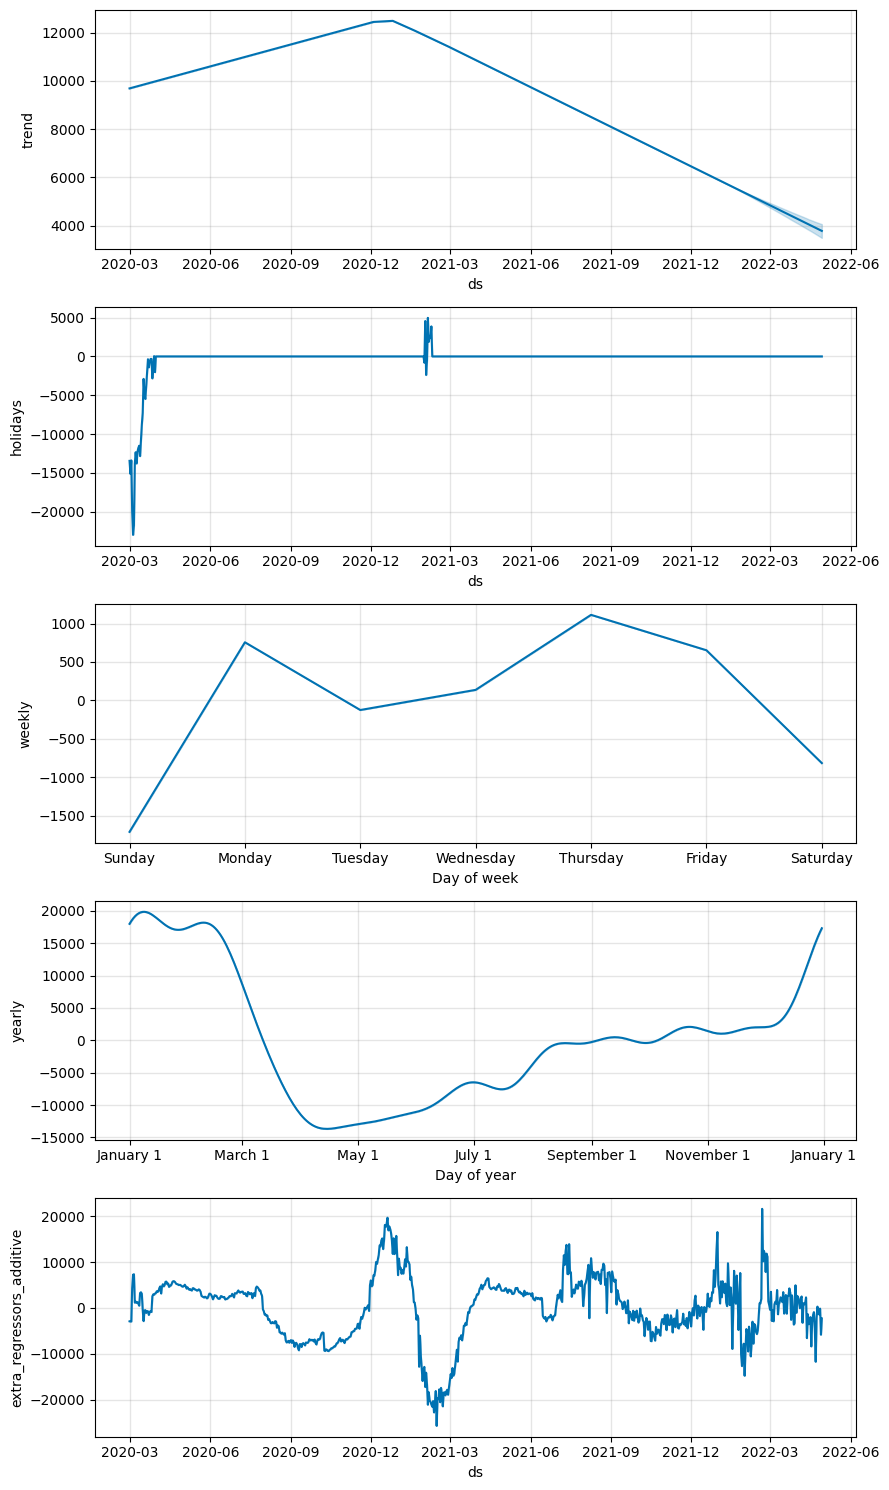

In [96]:
# Visualize the forecast components
model_holiday.plot_components(forecast_holiday);

In [112]:
# Merge actual and predicted values
performance_holiday = pd.merge(test_final, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])


# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
#print(f'Test MAPE {performance_holiday_MAPE}')

#naive forecast for mase calculation
naive_forecast = test_final['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(test_final['y'][1:], naive_forecast.dropna())
mase = performance_holiday_MAE / mae_naive

#calculate performance metrics
mae = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
mse = mean_squared_error(performance_holiday['y'], performance_holiday['yhat'])
rmse = np.sqrt(mse)
print(f'Test MAE: ', performance_holiday_MAE)
print('Test RMSE: ', rmse)
print('Test MASE: ', mase)


Test MAE:  18909.763721831012
Test RMSE:  20406.82644600647
Test MASE:  0.8084655995020477


HYPERPARAMETER TUNING

In [100]:
from prophet import Prophet
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define a wrapper for Prophet to use with GridSearchCV
class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='additive', holidays_prior_scale=10.0, seasonality_prior_scale=10.0):
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.seasonality_mode = seasonality_mode
        self.holidays_prior_scale = holidays_prior_scale
        self.seasonality_prior_scale = seasonality_prior_scale
        self.model = None

    def fit(self, X, y):
        self.model = Prophet(yearly_seasonality=self.yearly_seasonality,
                             weekly_seasonality=self.weekly_seasonality,
                             daily_seasonality=self.daily_seasonality,
                             seasonality_mode=self.seasonality_mode,
                             holidays_prior_scale=self.holidays_prior_scale,
                             seasonality_prior_scale=self.seasonality_prior_scale)
        # Assuming 'ds' is a column in X and y is the target
        df = pd.concat((X['ds'], y), axis=1)
        df.columns = ['ds', 'y']
        self.model.fit(df)
        return self

    def predict(self, X):
        forecast = self.model.predict(X)
        return forecast['yhat']

# Define your parameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10],
}

# Make a scorer for GridSearchCV
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Initialize GridSearchCV
grid = GridSearchCV(estimator=ProphetWrapper(), param_grid=param_grid, scoring=rmse_scorer, cv=3)

# Assuming train_final is your dataset and it includes 'ds' and 'y' columns
X = train_final[['ds']]  # The features including the date
y = train_final['y']  # The target variable

# Fit the GridSearchCV
grid.fit(X, y)

# Best parameters and score
print("Best parameters:", grid.best_params_)
print("Best RMSE:", grid.best_score_)


02:13:00 - cmdstanpy - INFO - Chain [1] start processing
02:13:00 - cmdstanpy - INFO - Chain [1] done processing
02:13:01 - cmdstanpy - INFO - Chain [1] start processing
02:13:01 - cmdstanpy - INFO - Chain [1] done processing
02:13:01 - cmdstanpy - INFO - Chain [1] start processing
02:13:01 - cmdstanpy - INFO - Chain [1] done processing
02:13:01 - cmdstanpy - INFO - Chain [1] start processing
02:13:01 - cmdstanpy - INFO - Chain [1] done processing
02:13:01 - cmdstanpy - INFO - Chain [1] start processing
02:13:01 - cmdstanpy - INFO - Chain [1] done processing
02:13:02 - cmdstanpy - INFO - Chain [1] start processing
02:13:02 - cmdstanpy - INFO - Chain [1] done processing
02:13:02 - cmdstanpy - INFO - Chain [1] start processing
02:13:02 - cmdstanpy - INFO - Chain [1] done processing
02:13:02 - cmdstanpy - INFO - Chain [1] start processing
02:13:02 - cmdstanpy - INFO - Chain [1] done processing
02:13:02 - cmdstanpy - INFO - Chain [1] start processing
02:13:02 - cmdstanpy - INFO - Chain [1]

Best parameters: {'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Best RMSE: 31062.660663251634


In [101]:
# Initialize the model with seasonality
model_holiday_tuned = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = events, holidays_prior_scale = 0.01, seasonality_mode = 'multiplicative', seasonality_prior_scale =  0.01)

# Add each regressor individually
regressor_names = ['2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']
for name in regressor_names:
    model_holiday_tuned.add_regressor(name, standardize=False)

# Fit the model on the training dataset
model_holiday_tuned.fit(train_final)

02:13:35 - cmdstanpy - INFO - Chain [1] start processing
02:13:35 - cmdstanpy - INFO - Chain [1] done processing


In [113]:
# Merge actual and predicted values
performance_holiday_tuned = pd.merge(test_final, forecast_holiday_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_holiday_MAE_tuned = mean_absolute_error(performance_holiday_tuned['y'], performance_holiday_tuned['yhat'])
print(f'Test MAE {performance_holiday_MAE_tuned}')

#calculate performance metrics
mae = mean_absolute_error(performance_holiday_tuned['y'], performance_holiday_tuned['yhat'])
mse = mean_squared_error(performance_holiday_tuned['y'], performance_holiday_tuned['yhat'])
rmse = np.sqrt(mse)
print('Test RMSE: ', rmse)

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday_tuned['y'], performance_holiday_tuned['yhat'])
#print(f'The MAPE for the tuned holiday/event model is {performance_holiday_MAPE}')

#naive forecast for mase calculation
naive_forecast = test_final['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(test_final['y'][1:], naive_forecast.dropna())
mase = performance_holiday_MAE_tuned / mae_naive
print('Test MASE: ', mase)

Test MAE 8505.557818626114
Test RMSE:  9323.530451076904
Test MASE:  0.36364552207472267


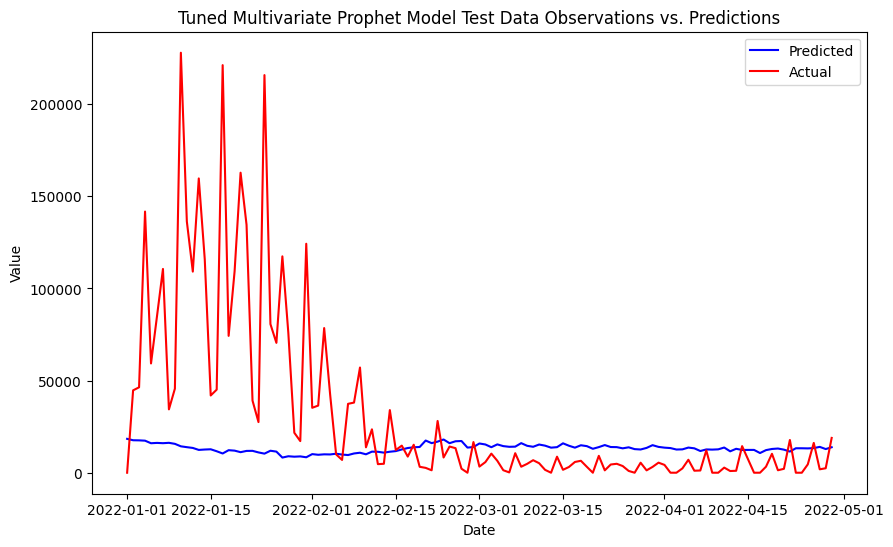

In [107]:
# Create the time range for the forecast
future_multivariate_holiday_tuned = model_holiday_tuned.make_future_dataframe(periods=120)

# Append the regressor values
future_multivariate_holiday_tuned = pd.merge(future_multivariate_holiday_tuned, full_df[['ds', '2', '7', '5', '15', '9', '6', '14', '31', '37', '39', '3', '36']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate_holiday_tuned = future_multivariate_holiday_tuned.fillna(method='ffill')

# Make prediction
forecast_multivariate_holiday_tuned = model_holiday_tuned.predict(future_multivariate_holiday_tuned)

# Predictions are already made in forecast_holiday, you need to filter this for the test period
test_period_start = test_final['ds'].min()
test_period_end = test_final['ds'].max()
forecast_test_period = forecast_multivariate_holiday_tuned[(forecast_multivariate_holiday_tuned['ds'] >= test_period_start)]

# Plot the predictions for the test period
plt.figure(figsize=(10, 6))
plt.plot(forecast_test_period['ds'], forecast_test_period['yhat'], label='Predicted', color='blue')

# Overlay the actual test data
plt.plot(test_final['ds'], test_final['y'], color='red', label='Actual')

# Enhance the plot with labels and legend
plt.legend()
plt.title('Tuned Multivariate Prophet Model Test Data Observations vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()
